## Training a CNN

In this lab we are going to be working with a ["17 Category Flower Dataset"](https://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html) from Visual Geometry Group of Oxford University.
We will acquire the data, split it, train multiple models and do some vizualizations. 

In [1]:
import numpy as np 
import pandas as pd 
import os 
import shutil 

### 1. Data aquisition

First, let's download the data from the webpage. You could have done it manually by going to the page, but we'll do it in the script.

In [2]:
import urllib

In [3]:
dataset_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz"
split_description_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/datasplits.mat"
#segmentation_ground_truth_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/trimaps.tgz"
readme_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/README.txt"

First, let's download the README file

In [4]:
# create folder to store data
data_folder = "data/"
os.makedirs(data_folder, exist_ok=True)

In [5]:
# let's write a function to download data as we'll use multiple times
def get_file(file_url, target_folder=""):
    filename = os.path.basename(file_url)
    # express explicitly the filepath where data will be downloaded
    target_filepath = os.path.join(target_folder, filename)
    filepath, response = urllib.request.urlretrieve(file_url, target_filepath)
    
    return filepath, response

In [6]:
# download readme file
readme_filepath, response = get_file(readme_url, data_folder)

In [7]:
# Check out the README
with open(readme_filepath, 'r') as readme:
    text = readme.read()
    print(text)

17 Flower Category Database
----------------------------------------------
This set contains images of flowers belonging to 17 different categories. 
The images were acquired by searching the web and taking pictures. There are
80 images for each category. 

The database was used in:

Nilsback, M-E. and Zisserman, A.  A Visual Vocabulary for Flower Classification.
Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (2006) 
http://www.robots.ox.ac.uk/~vgg/publications/papers/nilsback06.{pdf,ps.gz}.

The datasplits used in this paper are specified in datasplits.mat

There are 3 separate splits. The results in the paper are averaged over the 3 splits.
Each split has a training file (trn1,trn2,trn3), a validation file (val1, val2, val3)
and a testfile (tst1, tst2 or tst3). 

Segmentation Ground Truth
------------------------------------------------
The ground truth is given for a subset of the images from 13 different
categories. 

More details can be found in:

Ni

Now, let's download the data

In [8]:
# download the data
dataset_filepath, response = get_file(dataset_url, data_folder)

We have just downloaded a tar file. Let's unpack it.

In [9]:
import tarfile

In [10]:
with tarfile.open(dataset_filepath) as tar:
    tar.extractall(path=data_folder)

What have we extracted? 

In [11]:
os.listdir(data_folder)

['datasplits.mat',
 '17flowers.tgz',
 '.ipynb_checkpoints',
 'trimaps',
 'README.txt',
 'jpg',
 'trimaps.tgz']

We see that a new folder named *jpg* has appeared.

In [12]:
os.listdir(os.path.join(data_folder, 'jpg'))[:10]

['image_1063.jpg',
 'image_0674.jpg',
 'image_0116.jpg',
 'image_1329.jpg',
 'image_0945.jpg',
 'image_0544.jpg',
 'image_1135.jpg',
 'image_0635.jpg',
 'image_1178.jpg',
 'image_0936.jpg']

This folder contains images of the dataset. But what about ground truth?

Based on the README, each class contains exactly 80 images. Quick check shows that images of one class are grouped together. We will use this fact later to group the images by class.

The split information was already provided with the dataset (otherwise we could have used train_test_split to obtain it)

In [13]:
# download split file
split_filepath, response = get_file(split_description_url, data_folder)

In [14]:
from scipy.io import loadmat
split = loadmat(split_filepath)

In [15]:
split.keys()

dict_keys(['__header__', '__version__', '__globals__', 'trn1', 'trn2', 'trn3', 'tst1', 'tst2', 'tst3', 'val3', 'val2', 'val1'])

Let's use option 1 of train/val/test split:

In [16]:
train = split["trn1"]
val = split["val1"]
test = split["tst1"]

print("""Train set contains {} files, 
val set contains {} files, 
and test set contains {} files""".format(train.shape[1], val.shape[1], test.shape[1]))


Train set contains 680 files, 
val set contains 340 files, 
and test set contains 340 files


##### Excercise
Additional things to do:
- Check how many images we have downloaded.
- Display some of the images.
- Are those color images? 
- What are their shape? 
- Are they all of the same shape?

### 2. Data regrouping

During the training with Keras for the simplicity we are going to be using flow_from_dir method of ImageDataGenerator. However, we'll need to organize data first in the specific manner: separate train, val, test sets, and put images of each class in a designated folder. 


First, let's write a function to get a class name from file index. We'll use the fact that each class has 80 images, and they are grouped together by index. 

In [17]:
def get_image_class(file_index):
    image_class_idx = (int(file_index) - 1) // 80 + 1
    class_name = "{:02d}".format(image_class_idx)
    
    return class_name

Now let's rearrange the data

In [18]:
from shutil import copy

In [19]:
training_folder_name = "training_folder"

In [20]:
for filename in os.listdir(os.path.join(data_folder, 'jpg')):
    if filename.endswith('jpg'):
        ### filename 'image_0936.jpg' --> file_index 936
        file_index = int(filename[6:10])
        true_class = get_image_class(file_index)
        if file_index in train:
            split_folder = 'train'
        elif file_index in val:
            split_folder = 'val'
        elif file_index in test:
            split_folder = 'test'     
        
        target_folder = os.path.join(data_folder, training_folder_name, split_folder, true_class)
        os.makedirs(target_folder, exist_ok=True)
        
        source_filepath = os.path.join(data_folder, 'jpg', filename)
        copy(source_filepath, target_folder)
    else:
        print(filename)
        print("Not a jpg file, skipping")
    

files.txt~
Not a jpg file, skipping
files.txt
Not a jpg file, skipping


### 3. CNN training

Now that we have prepared the data, we will be able to train a model.

#### 3.1 Transfer learning

Let's do the [transfer learning](https://papers.nips.cc/paper/5347-how-transferable-are-features-in-deep-neural-networks.pdf) we have briefly discussed last time. We'll load one of the pretrained models from Keras library with [ImageNet weights](http://www.image-net.org/).

##### Model preparation

In [40]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

import os

In [41]:
## GPU selection --> execute do only if you need to select a GPU / part of GPU

os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

### Set session with share of GPU
config_1 = tf.ConfigProto()
gpu_fraction_1 = float(os.environ.get('GPU_LIMIT_1', 0.45))
config_1.gpu_options.per_process_gpu_memory_fraction = gpu_fraction_1
config_1.gpu_options.allow_growth = True

sess_1 = tf.Session(config=config_1)
sess_1.run(tf.global_variables_initializer())
K.set_session(sess_1)

We'll be using VGG16 model. Together with weights, we'll also need a corresponding preprocessing function for the input images.

In [42]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg

from keras.layers import Dense, Dropout, Flatten
from keras.models import Model

In [43]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape = (224,224,3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Note that we have downloaded only a convolution part of the neural network. Let's add some dense layers on top of it.

In [44]:
nb_classes = 17

In [45]:
flatten = Flatten()(base_model.output)
dropout_1 = Dropout(0.25)(flatten)
fc_1 = Dense(1000)(dropout_1)
dropout_2 = Dropout(0.5)(fc_1)
predictions = Dense(nb_classes, activation="softmax", name='predictions')(dropout_2)

In [46]:
model = Model(input=base_model.input, output=predictions)

/cyclope/nshvai/.nshvai/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [47]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

##### Model training parameters

In [48]:
from keras import optimizers

In [49]:
loss = 'categorical_crossentropy'
learning_rate = 0.001
optimizer = optimizers.SGD ## optimizers.SGD ## optimizers.RMSprop ## optimizers.Adagrad
metrics = ['accuracy']

In [50]:
model.compile(loss=loss,
              optimizer=optimizer(learning_rate),
              metrics=metrics)

##### Data preparation

In [51]:
from keras.preprocessing.image import ImageDataGenerator

In [52]:
train_dir = os.path.join(data_folder, training_folder_name, "train")
val_dir = os.path.join(data_folder, training_folder_name, "val")
test_dir = os.path.join(data_folder, training_folder_name, "test")

In [53]:
# we'll resize images in correspondance to network input size
image_size = (224,224)

In [54]:
# apply some data augmentation
train_datagen = ImageDataGenerator(rotation_range=15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=preprocess_input_vgg
                                  )

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg) # for validation we don't need to augment

train_batchsize = 80
val_batchsize = 80

# this function takes images from folders and feeds to Imagedatagenerator
train_generator = train_datagen.flow_from_directory( 
        train_dir,
        target_size=image_size,
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 680 images belonging to 17 classes.
Found 340 images belonging to 17 classes.


##### Model training

In [55]:
epochs = 50

In [56]:
nb_train_steps = train_generator.samples // train_generator.batch_size
nb_val_steps = validation_generator.samples // validation_generator.batch_size

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=nb_train_steps,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_val_steps,
      verbose=1, #0
)

Epoch 1/50
8/8 [==============================] - 15s 2s/step - loss: 12.2589 - accuracy: 0.0900 - val_loss: 2.8952 - val_accuracy: 0.1375
Epoch 2/50
8/8 [==============================] - 16s 2s/step - loss: 2.9713 - accuracy: 0.0984 - val_loss: 2.4470 - val_accuracy: 0.1154
Epoch 3/50
8/8 [==============================] - 13s 2s/step - loss: 2.8518 - accuracy: 0.0893 - val_loss: 2.7958 - val_accuracy: 0.0538
Epoch 4/50
8/8 [==============================] - 14s 2s/step - loss: 2.7998 - accuracy: 0.0812 - val_loss: 2.8718 - val_accuracy: 0.1308
Epoch 5/50
8/8 [==============================] - 12s 2s/step - loss: 2.7558 - accuracy: 0.0917 - val_loss: 2.8591 - val_accuracy: 0.1462
Epoch 6/50
8/8 [==============================] - 12s 2s/step - loss: 2.8159 - accuracy: 0.1054 - val_loss: 2.7740 - val_accuracy: 0.0969
Epoch 7/50
8/8 [==============================] - 16s 2s/step - loss: 2.8091 - accuracy: 0.0875 - val_loss: 2.2211 - val_accuracy: 0.1500
Epoch 8/50
8/8 [=================

In [68]:
print('training acc.:',history.history['accuracy'][-1])
print('val acc.:', (history.history['val_accuracy'])[-1])

training acc.: 0.59
val acc.: 0.6846153736114502


In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy %')
    plt.plot(history.epoch, np.array(history.history['accuracy']),
    label='Train Accuracy')
    plt.plot(history.epoch, np.array(history.history['val_accuracy']),
    label = 'Val Accuracy')
    plt.legend()
    plt.ylim([0, 1])

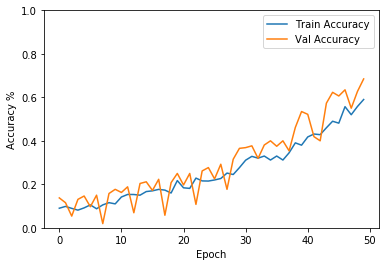

In [70]:
plot_history(history)

##### Save model

In [71]:
weights_folder = "weights"
os.makedirs(weights_folder, exist_ok=True)

In [72]:
model_name = 'vgg16_transfer_weights.h5'

In [73]:
model_path = os.path.join(weights_folder, model_name)

In [78]:
#model.save(model_path)

##### Do the test on images

In [79]:
from keras.preprocessing import image
from keras.models import load_model

In [80]:
model = load_model(model_path)

###### Single image prediction

In [95]:
class_idx = '07'
image_name = os.listdir(os.path.join(test_dir, class_idx))[0]
image_path = os.path.join(test_dir, class_idx, image_name)

In [96]:
# predicting image: getting the output vector
img = image.load_img(image_path, target_size=image_size)
img_array = image.img_to_array(img)
img_expanded = np.expand_dims(img_array, axis=0)
preprocessed_image = preprocess_input_vgg(img_expanded)

pred = model.predict(preprocessed_image)
print(pred)

[[1.5288817e-17 1.4129310e-20 1.2092929e-17 4.3464738e-21 5.1470821e-18
  1.5839364e-19 1.0000000e+00 3.6123461e-18 3.7224653e-19 2.4319075e-22
  1.0156736e-16 7.7484472e-16 5.6257878e-20 6.5562739e-19 5.5429071e-18
  1.1861455e-20 3.5595567e-19]]


In [97]:
classes = ["{:02d}".format(i) for i in range(1, 18)]
pred_class_idx = np.argmax(pred, axis=1)
classes[pred_class_idx[0]]

'07'

###### Multiple image predictions

In [101]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns; sns.set()

In [92]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg) 

In [93]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps=nb_samples)

Found 340 images belonging to 17 classes.


Confusion Matrix


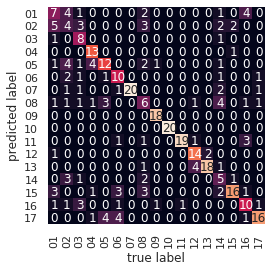

In [103]:
y_pred = np.argmax(predict, axis=1)
print('Confusion Matrix')

mat = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [104]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.37      0.35      0.36        20
           1       0.21      0.20      0.21        20
           2       0.80      0.40      0.53        20
           3       0.93      0.65      0.76        20
           4       0.46      0.60      0.52        20
           5       0.62      0.50      0.56        20
           6       0.77      1.00      0.87        20
           7       0.30      0.30      0.30        20
           8       1.00      0.90      0.95        20
           9       1.00      1.00      1.00        20
          10       0.76      0.95      0.84        20
          11       0.82      0.70      0.76        20
          12       0.75      0.90      0.82        20
          13       0.42      0.25      0.31        20
          14       0.55      0.80      0.65        20
          15       0.53      0.50      0.51        20
          16       0.62      0.80      0.70        20

    accuracy              

Things to do

- Check some of incorrectly classified images
- Experiment with other models available in Keras
- Build your own network
- Optimize one or several training hyperparameters

#### 3.2 Training enhancement

There are multiple ways to improve the quality of the model. Have a look at these papers that provide some heuristics for training a [classification](https://arxiv.org/pdf/1812.01187.pdf) or [object detection](https://arxiv.org/pdf/1902.04103.pdf) model.

##### 3.2.1 Data augmentation

Better data augmentation can easily give a boost to a model. Some of the useful tools include
- [imgaug](https://github.com/aleju/imgaug)
- [mixup](https://arxiv.org/pdf/1710.09412.pdf)

##### 3.2.2 Learning rate scheduling and early stopping criteria

In Keras learning rate scheduling and early stopping criteria can be implemented using [Callbacks](https://keras.io/callbacks/). In particular, the following are quite useful: LearningRateScheduler, ReduceLROnPlateau, EarlyStopping,  CSVLogger, ModelCheckpoint.